## Tic-Tac-Toe Agent
​
In this notebook, I have implemented an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
    - Defining epsilon-greedy strategy
    - Tracking state-action pairs for convergence
    - Define hyperparameters for the Q-learning algorithm
    - Generating episode and applying Q-update equation
    - Checking convergence in Q-values

### Importing libraries

In [1]:
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from TCGame_env import TicTacToe
from tqdm import tqdm

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

### Epsilon-greedy strategy

In [5]:
# Defining epsilon-greedy policy.
def epsilon_greedy(state, time):
    max_epsilon = 1.0
    min_epsilon = 0.001

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()       
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)
    else:
        action = random.sample(valid_actions(state),1)[0]   
    
    return action

### Tracking the state-action pairs for checking convergence

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

## For retraining with already trained Policy learned
# with open('Policy.pkl', 'rb') as handle:
#     Q_dict = pickle.load(handle)
      

# with open('States_tracked.pkl', 'rb') as handle:
#     States_track = pickle.load(handle)    
    
print(len(Q_dict))
print(len(States_track))

0
0


In [7]:
# Initialise few random states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-3-x-x-x-6-x-x-x',(0,1)),
                       ('x-1-x-x-x-x-8-x-x',(2,9)),
                       ('x-x-x-x-6-x-x-x-5',(2,7)),
                       ('x-x-x-x-9-x-6-x-x',(1,7)),
                       ('x-5-x-2-x-x-4-7-x',(0,9)),
                       ('9-x-5-x-x-x-8-x-4',(1,3)),
                       ('2-7-x-x-6-x-x-3-x',(8,5)),
                       ('9-x-x-x-x-2-x-x-x',(2,5)),
                       ('x-x-7-x-x-x-x-x-2',(1,5)),
                       ('5-x-x-x-x-6-x-x-x',(4,9)),
                       ('4-x-x-6-x-x-3-1-x',(8,5)),
                       ('5-x-8-x-x-6-3-x-x',(3,1)),
                       ('x-6-5-x-2-x-x-3-x',(0,7)),
                       ('7-x-5-x-2-x-x-x-6',(1,3))]
    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [8]:
# Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
# Defining a function to track the states initialized
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

### Define hyperparameters

In [11]:
EPISODES = 6000000
LR = 0.20
GAMMA = 0.8
threshold = 2540
checkpoint_print_episodes = 600000

### Q-update loop

In [12]:
start_time = time.time()

q_track={}
q_track['x-3-x-x-x-6-x-x-x']=[]
q_track['x-1-x-x-x-x-8-x-x']=[]
q_track['x-x-x-x-6-x-x-x-5']=[]
q_track['x-x-x-x-9-x-6-x-x']=[]
q_track['x-5-x-2-x-x-4-7-x']=[]
q_track['9-x-5-x-x-x-8-x-4']=[]
q_track['2-7-x-x-6-x-x-3-x']=[]
q_track['9-x-x-x-x-2-x-x-x']=[]
q_track['x-x-7-x-x-x-x-x-2']=[]
q_track['5-x-x-x-x-6-x-x-x']=[]
q_track['4-x-x-6-x-x-3-1-x']=[]
q_track['5-x-8-x-x-6-3-x-x']=[]
q_track['x-6-5-x-2-x-x-3-x']=[]
q_track['7-x-5-x-2-x-x-x-6']=[]   
                    
agent_won_count = 0
env_won_count = 0
tie_count = 0

for episode in tqdm(range(EPISODES)):
    
    env = TicTacToe()
    
    ## Initalizing parameter for the episodes
    reward=0
    curr_state = env.state
    add_to_dict(curr_state)
    is_terminal = False
    total_reward = 0
    
    while not(is_terminal):
        curr_action = epsilon_greedy(curr_state, episode)
    
        if Q_state(curr_state) in q_track.keys():
            q_track[Q_state(curr_state)].append(curr_action)

        next_state,reward,is_terminal, msg = env.step(curr_state,curr_action) 

        curr_lookup = Q_state(curr_state)
        next_lookup = Q_state(next_state)

        if is_terminal:
            q_value_max = 0
            
            # Tracking the count of games won by agent and environment
            if msg == "Agent Won!":
                agent_won_count += 1
            elif msg == "Environment Won!":
                env_won_count += 1
            else:
                tie_count += 1
        else:
            add_to_dict(next_state)
            max_next = max(Q_dict[next_lookup],key=Q_dict[next_lookup].get)
            q_value_max = Q_dict[next_lookup][max_next]

        Q_dict[curr_lookup][curr_action] += LR * ((reward + (GAMMA * (q_value_max))) - Q_dict[curr_lookup][curr_action]) 
        curr_state = next_state

        total_reward += reward

    if (episode + 1) % checkpoint_print_episodes == 0:
        print("After playing %d games, Agent Won : %.4f, Environment Won : %.4f, Tie : %.4f"% (episode + 1, 
            agent_won_count / (episode + 1), env_won_count /(episode + 1), tie_count / (episode + 1)))

    if ((episode + 1) % threshold) == 0:   
        save_tracking_states()

    if ((episode + 1) % 1000000) == 0:
        print('Processed %dM episodes'%((episode+1)/1000000))
        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')
save_obj(Q_dict,'Policy')
print('Total Execution time: ', elapsed_time)

 10%|█         | 600070/6000000 [13:47<2:04:54, 720.51it/s] 

After playing 600000 games, Agent Won : 0.2962, Environment Won : 0.2654, Tie : 0.4385


 17%|█▋        | 1000125/6000000 [21:57<1:20:14, 1038.50it/s]

Processed 1M episodes


 20%|██        | 1200174/6000000 [26:09<1:26:01, 929.90it/s] 

After playing 1200000 games, Agent Won : 0.4195, Environment Won : 0.2202, Tie : 0.3603


 30%|███       | 1800118/6000000 [37:26<1:04:06, 1091.93it/s]

After playing 1800000 games, Agent Won : 0.5282, Environment Won : 0.1805, Tie : 0.2913


 33%|███▎      | 2000181/6000000 [40:49<58:09, 1146.10it/s]  

Processed 2M episodes


 40%|████      | 2400159/6000000 [46:59<48:35, 1234.63it/s]  

After playing 2400000 games, Agent Won : 0.6092, Environment Won : 0.1500, Tie : 0.2408


 50%|█████     | 3000182/6000000 [55:58<39:28, 1266.33it/s] 

After playing 3000000 games, Agent Won : 0.6690, Environment Won : 0.1265, Tie : 0.2045
Processed 3M episodes


 60%|██████    | 3600154/6000000 [1:04:39<44:49, 892.32it/s]  

After playing 3600000 games, Agent Won : 0.7149, Environment Won : 0.1082, Tie : 0.1769


 67%|██████▋   | 4000229/6000000 [1:10:04<22:19, 1492.96it/s] 

Processed 4M episodes


 70%|███████   | 4200240/6000000 [1:12:24<22:16, 1346.51it/s]

After playing 4200000 games, Agent Won : 0.7506, Environment Won : 0.0939, Tie : 0.1554


 80%|████████  | 4800190/6000000 [1:20:41<20:02, 997.69it/s]  

After playing 4800000 games, Agent Won : 0.7788, Environment Won : 0.0828, Tie : 0.1384


 83%|████████▎ | 5000170/6000000 [1:23:35<13:23, 1243.78it/s]

Processed 5M episodes


 90%|█████████ | 5400186/6000000 [1:29:20<07:56, 1258.13it/s]

After playing 5400000 games, Agent Won : 0.8013, Environment Won : 0.0739, Tie : 0.1248


100%|██████████| 6000000/6000000 [1:37:12<00:00, 1028.73it/s]


After playing 6000000 games, Agent Won : 0.8197, Environment Won : 0.0667, Tie : 0.1136
Processed 6M episodes
Total Execution time:  5832.467136859894


### Checking the Q-dictionary

In [14]:
len(Q_dict)

1267121

In [15]:
# Checking for one of the states
Q_dict['x-x-5-x-x-x-x-x-4']

{(0, 1): -1.0764380483629874,
 (0, 3): -1.047259037233907,
 (0, 7): -0.5929303746265571,
 (0, 9): 2.340190070964205,
 (1, 1): -2.567347787817046,
 (1, 3): -0.21804431810216657,
 (1, 7): -2.8613332697655762,
 (1, 9): -0.7670664863574737,
 (3, 1): -0.95601953488896,
 (3, 3): -1.0057569438410892,
 (3, 7): -0.9648156279111679,
 (3, 9): -0.9727665159631451,
 (4, 1): -2.218281361896413,
 (4, 3): -2.483303249543168,
 (4, 7): -1.315282823122518,
 (4, 9): -0.8028843103289344,
 (5, 1): -0.6240992671705161,
 (5, 3): -0.6782155804739437,
 (5, 7): -0.981985601490518,
 (5, 9): -0.9141006540800001,
 (6, 1): -2.960897912263148,
 (6, 3): -2.8748684811924146,
 (6, 7): -0.9326422428452508,
 (6, 9): -0.9718525023289344,
 (7, 1): -1.518378510290518,
 (7, 3): -0.9774820018631475,
 (7, 7): -0.8926258176,
 (7, 9): -2.7735068948889596}

### Checking the states tracked for Q-values convergence

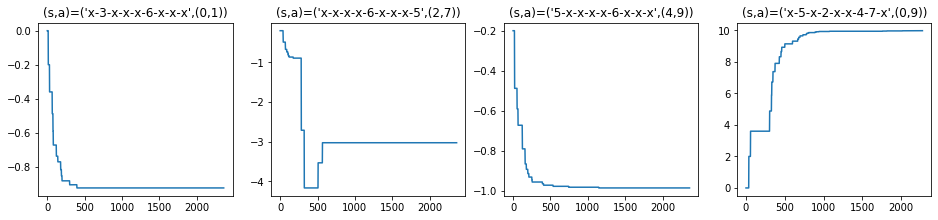

In [16]:
plt.figure(0, figsize=(16,7))
plt.subplot(241)
t1=States_track['x-3-x-x-x-6-x-x-x'][(0,1)]
plt.title("(s,a)=('x-3-x-x-x-6-x-x-x',(0,1))")
plt.plot(np.asarray(range(0, len(t1))),np.asarray(t1))

plt.subplot(242)
t2=States_track['x-x-x-x-6-x-x-x-5'][(2,7)]
plt.title("(s,a)=('x-x-x-x-6-x-x-x-5',(2,7))")
plt.plot(np.asarray(range(0, len(t2))),np.asarray(t2))

plt.subplot(243)
t3=States_track['5-x-x-x-x-6-x-x-x'][(4,9)]
plt.title("(s,a)=('5-x-x-x-x-6-x-x-x',(4,9))")
plt.plot(np.asarray(range(0, len(t3))),np.asarray(t3))

plt.subplot(244)
t4=States_track['x-5-x-2-x-x-4-7-x'][(0,9)]
plt.title("(s,a)=('x-5-x-2-x-x-4-7-x',(0,9))")
plt.plot(np.asarray(range(0, len(t4))),np.asarray(t4))

plt.show()